In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from ultralytics import YOLO
import joblib
import math



In [2]:
meta = {'c0': "Focussed",
         'c1' : "Text-Phone Right",
           'c2': "Talk-Phone Right", 
           'c3': "Text-Phone Left", 
           'c4': "Talk-Phone Left", 
           'c5': "Radio Adjust", 
           'c6': "Drinking", 
           'c7': "Back Seat Reach", 
           'c8': "Misc Manual", 
           'c9': "Visual"
}

In [3]:
meta_points_disc = {"p1": "nose",
                    "p2": "L_eye",
                    "p3": "R_eye",
                    "p4": "L_ear",
                    "p5": "R_ear",
                    "p6": "L_shoulder",
                    "p7": "R_shoulder",
                    "p8": "L_elbow",
                    "p9": "R_elbow",
                    "p10": "L_wrist",
                    "p11": "R_wrist",
                    "p12": "L_hip",
                    "p13": "R_hip",
                    "p14": "L_Knee",
                    "p15": "R_Knee",
                    "p16": "L_ankle",
                    "p17": "R_ankle",
                    "p18": "Top_left_box",
                    "p19": "Top_right_box",
                    "p20": "Bottom_right_box",
                    "p21": "Bottom_right_box",
                    "p22": "Top_left_box_sw",
                    "p23": "Top_right_box_sw",
                    "p24": "Bottom_right_box_sw",
                    "p25": "Bottom_right_box_sw"
                    }

In [4]:
meta_expl_att = {"p1": "posture_angle_L",
                 "p2": "posture_angle_R",
                 "p3": "elbow_angle_L",
                 "p4": "elbow_angle_R",
                 "p5": "Dist_Wrist_2_SW_R",
                 "p6": "Dist_Wrist_2_SW_L",
                 "p7": "Dist_Wrist_2_Ear_R",
                 "p8": "Dist_Wrist_2_Ear_L",
                 "p9": "Dist_Hor_center_SW_2_Shoulder_to_elbow_R",
                 "p10": "Dist_Hor_center_SW_2_Shoulder_to_elbow_L",
                 "p11": "Dist_Hor_Wrist_2_SW_R",
                 "p12": "Dist_Vert_Wrist_2_SW_R",
                 "p13": "Vector_Dist_Shoulders_L_2_R",
                 "p14": "Vector_Angle_Shoulders_L_2_R",
                 "p15": "Vector_Dist_Eyes_L2R",
                 "p16": "Vector_Dist_Ears_L2R",
                 }

In [5]:
defualt = {'X_coord': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},
    'Y_coord': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},
    'Z_coord/conf': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},}

In [6]:
pose_model = YOLO(r"C:/Users/james/Desktop/Diss_project_code/Pretrained_models/yolov8n-pose.pt")
box_model = YOLO(r"C:/Users/james/Desktop/Diss_project_code/Pretrained_models/Steering_wheel.pt")

In [7]:
def get_corners(box):
    box_coords = box.xywhn.numpy()[0]
    TopLeft = [(box_coords[0]-box_coords[2]/2),(box_coords[1]+box_coords[3]/2)]
    TopRight = [(box_coords[0]+box_coords[2]/2),(box_coords[1]+box_coords[3]/2)]
    BottomLeft = [(box_coords[0]-box_coords[2]/2),(box_coords[1]-box_coords[3]/2)]
    BottomRight = [(box_coords[0]+box_coords[2]/2),(box_coords[1]-box_coords[3]/2)]

    box_coords = [TopLeft, TopRight, BottomLeft, BottomRight]
    box_conf = [box.conf.numpy()[0]]*4
    box_coords = np.array(box_coords, dtype=np.float32)
    box_conf = np.array(box_conf, dtype=np.float32)
    return box_coords, box_conf

def create_full_dict(SW_results, results):
    keypoint = results[0]
    points = keypoint.keypoints.xyn.numpy()[0]
    box_coords, box_conf = get_corners(keypoint.boxes)
    points = np.vstack((points, box_coords))
    if len(SW_results[0].boxes.conf) != 0:
        seg_box_coords, seg_box_conf = get_corners(SW_results[0].boxes)
    else:
        seg_box_coords = np.array([[0,0]]*4)
        seg_box_conf = [0]*4
    points = np.vstack((points, seg_box_coords)) 
    column_names = ["X_coord", "Y_coord"]
    points_df = pd.DataFrame(data = points, columns=column_names)
    confidence = keypoint.keypoints.conf.numpy()[0]
    confidence = np.concatenate([confidence, box_conf, seg_box_conf])
    points_df["Z_coord/conf"] = confidence
    points_df.index = list(meta_points_disc.keys())
    points_dict = points_df.to_dict()
    return points_dict

In [8]:
def get_landmarks(pose_model, box_model, image_dir):
    results = pose_model(image_dir, conf=0.6)
    SW_results = box_model(image_dir, conf=0.6)
    if results[0].keypoints.conf != None:
        cls_dict = create_full_dict(SW_results, results)
    else:
        cls_dict = defualt
    return cls_dict
        

In [9]:
def standardize(coord_list):
    mean = np.mean(coord_list)
    std_dev = np.std(coord_list)
    standardize = []
    for i in coord_list:
        standardize.append((i-mean)/std_dev)
    return standardize

In [10]:
def vector_calculation(p1_list, p2_list):
    vector = [p2_list[0] - p1_list[0], p2_list[1] - p1_list[1]]
    if vector != [0,0]: #prevents undefined condition
        length = math.sqrt(vector[0]**2 + vector[1]**2) 
        angle = math.degrees(math.acos(vector[0] / length))
    else:
        length = 0
        angle = 0
    return vector, angle, length

In [11]:
def get_horizontal_vertical_dist(coord1, coord2):
    horizontal = coord1[0] - coord2[0]
    vertical = coord1[1] - coord2[1]
    return horizontal, vertical

In [12]:
def half_length(coord1, coord2):
    x = (coord1[0] + coord2[0])/2
    y = (coord1[0] + coord2[0])/2
    return x, y

In [13]:
def center_sw(top_L, bottom_R):
    x = (bottom_R[0] + top_L[0])/2
    y = (bottom_R[1] + top_L[1])/2
    return x, y

In [14]:
def create_attribute_list(coords_df):
    att1 = vector_calculation(list(coords_df.loc["p6"]), list(coords_df.loc["p12"]))[1] # Posture Angle L
    att2 = vector_calculation(list(coords_df.loc["p7"]), list(coords_df.loc["p13"]))[1] # Posture Angle R
    att3 = vector_calculation(list(coords_df.loc["p6"]), list(coords_df.loc["p8"]))[1] - vector_calculation(list(coords_df.loc["p8"]), list(coords_df.loc["p10"]))[1] # Elbow angle L
    att4 = vector_calculation(list(coords_df.loc["p7"]), list(coords_df.loc["p9"]))[1] - vector_calculation(list(coords_df.loc["p7"]), list(coords_df.loc["p11"]))[1] # Elbow Angle R
    att5 = vector_calculation(list(coords_df.loc["p10"]), center_sw(coords_df.loc["p22"], coords_df.loc["p25"]))[2] # Dist Wrist-SW L 
    att6 = vector_calculation(list(coords_df.loc["p11"]), center_sw(coords_df.loc["p22"], coords_df.loc["p25"]))[2] # Dist Wrist-SW R
    att7 = vector_calculation(list(coords_df.loc["p10"]), list(coords_df.loc["p2"]))[2] # Dist Wrist - Ears L
    att8 = vector_calculation(list(coords_df.loc["p11"]), list(coords_df.loc["p3"]))[2] # Dist Wrist - Ears R
    att9 = vector_calculation(list(coords_df.loc["p10"]), list(coords_df.loc["p1"]))[2] # Dist Wrist - nose L
    att10 = vector_calculation(list(coords_df.loc["p11"]), list(coords_df.loc["p1"]))[2] # Dist Wrist - nose R
    att11 = get_horizontal_vertical_dist(list(half_length(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p6"]))), list(coords_df.loc["p8"]))[0] # Hor Dist to (center point between SW and Should) - Wrist L
    att12 = get_horizontal_vertical_dist(list(half_length(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p7"]))), list(coords_df.loc["p9"]))[0] # Hor Dist to (center point between SW and Should) - Wrist R
    att13 = get_horizontal_vertical_dist(list(half_length(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p6"]))), list(coords_df.loc["p8"]))[1] # Vert Dist to (center point between SW and Should) - Wrist R
    att14 = get_horizontal_vertical_dist(list(half_length(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p7"]))), list(coords_df.loc["p9"]))[1] # Vert Dist to (center point between SW and Should) - Wrist R
    att15 = get_horizontal_vertical_dist(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p11"]))[0] # Hor Dist Wrist - SW R
    att16 = get_horizontal_vertical_dist(list(center_sw(coords_df.loc["p22"], coords_df.loc["p25"])), list(coords_df.loc["p11"]))[1] # Vert Dist Wrist - SW R
    att17 = vector_calculation(list(coords_df.loc["p6"]), list(coords_df.loc["p7"]))[2] # Hor Left shoulder - Right Shoulder
    att18 = vector_calculation(list(coords_df.loc["p6"]), list(coords_df.loc["p7"]))[1] # Angle Left Shoulder - Right Shoulder
    att19 = vector_calculation(list(coords_df.loc["p2"]), list(coords_df.loc["p3"]))[2] # Hor Left hip - Right hip
    att20 = vector_calculation(list(coords_df.loc["p4"]), list(coords_df.loc["p5"]))[2] # Angle Left hip - Right hip
    att_list = [att1, att2, att3, att4, att5, att6, att7, att8, att9, att10, att11, att12 ,att13, att14, att15, att16, att17, att18, att19, att20]
    return att_list

In [15]:
def dict_2_input(landmark_dict):
    lm_dataframe = pd.DataFrame(landmark_dict)
    X = create_attribute_list(lm_dataframe)
    return X

In [16]:
def create_inputs(pose_model, box_model, image_dir):
    dict_lm = get_landmarks(pose_model,box_model, image_dir)
    X = dict_2_input(dict_lm)
    X = np.array(X)
    X = X.reshape(-1, 1)
    X = X.T
    return X

In [17]:
X = create_inputs(pose_model, box_model, r"C:/Users/james/Desktop/Diss_project_code/state-farm-distracted-driver-detection/imgs/Unlabled/test/img_64637.jpg")


image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_64637.jpg: 480x640 1 person, 131.8ms
Speed: 15.6ms preprocess, 131.8ms inference, 10.2ms postprocess per image at shape (1, 3, 480, 640)



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_64637.jpg: 480x640 1 Steering Wheel, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Load Decision Tree

In [18]:

model = joblib.load(r"C:/Users/james/Desktop/Diss_Code_for_AUC/Target_Attributes/random_forest_model.pkl")



In [19]:
prediction = model.predict(X)

prediction

array(['c2'], dtype=object)

In [20]:
print("Predicted probabilities for each class:")
print(np.argmax(prediction))

Predicted probabilities for each class:
0


In [21]:
meta_cls_2_num = {'c0': 0,
         'c1' : 1,
           'c2': 2, 
           'c3': 3, 
           'c4': 4, 
           'c5': 5, 
           'c6': 6, 
           'c7': 7, 
           'c8': 8, 
           'c9': 9
}

IF SF DATASET CAN BE USED!!!!

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_384.jpg: 480x640 1 person, 102.4ms
Speed: 2.4ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_384.jpg: 480x640 1 Steering Wheel, 69.2ms
Speed: 13.3ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_413.jpg: 480x640 1 person, 63.3ms
Speed: 0.0ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_413.jpg: 480x640 1 Steering Wheel, 60.7ms
Speed: 0.0ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

i

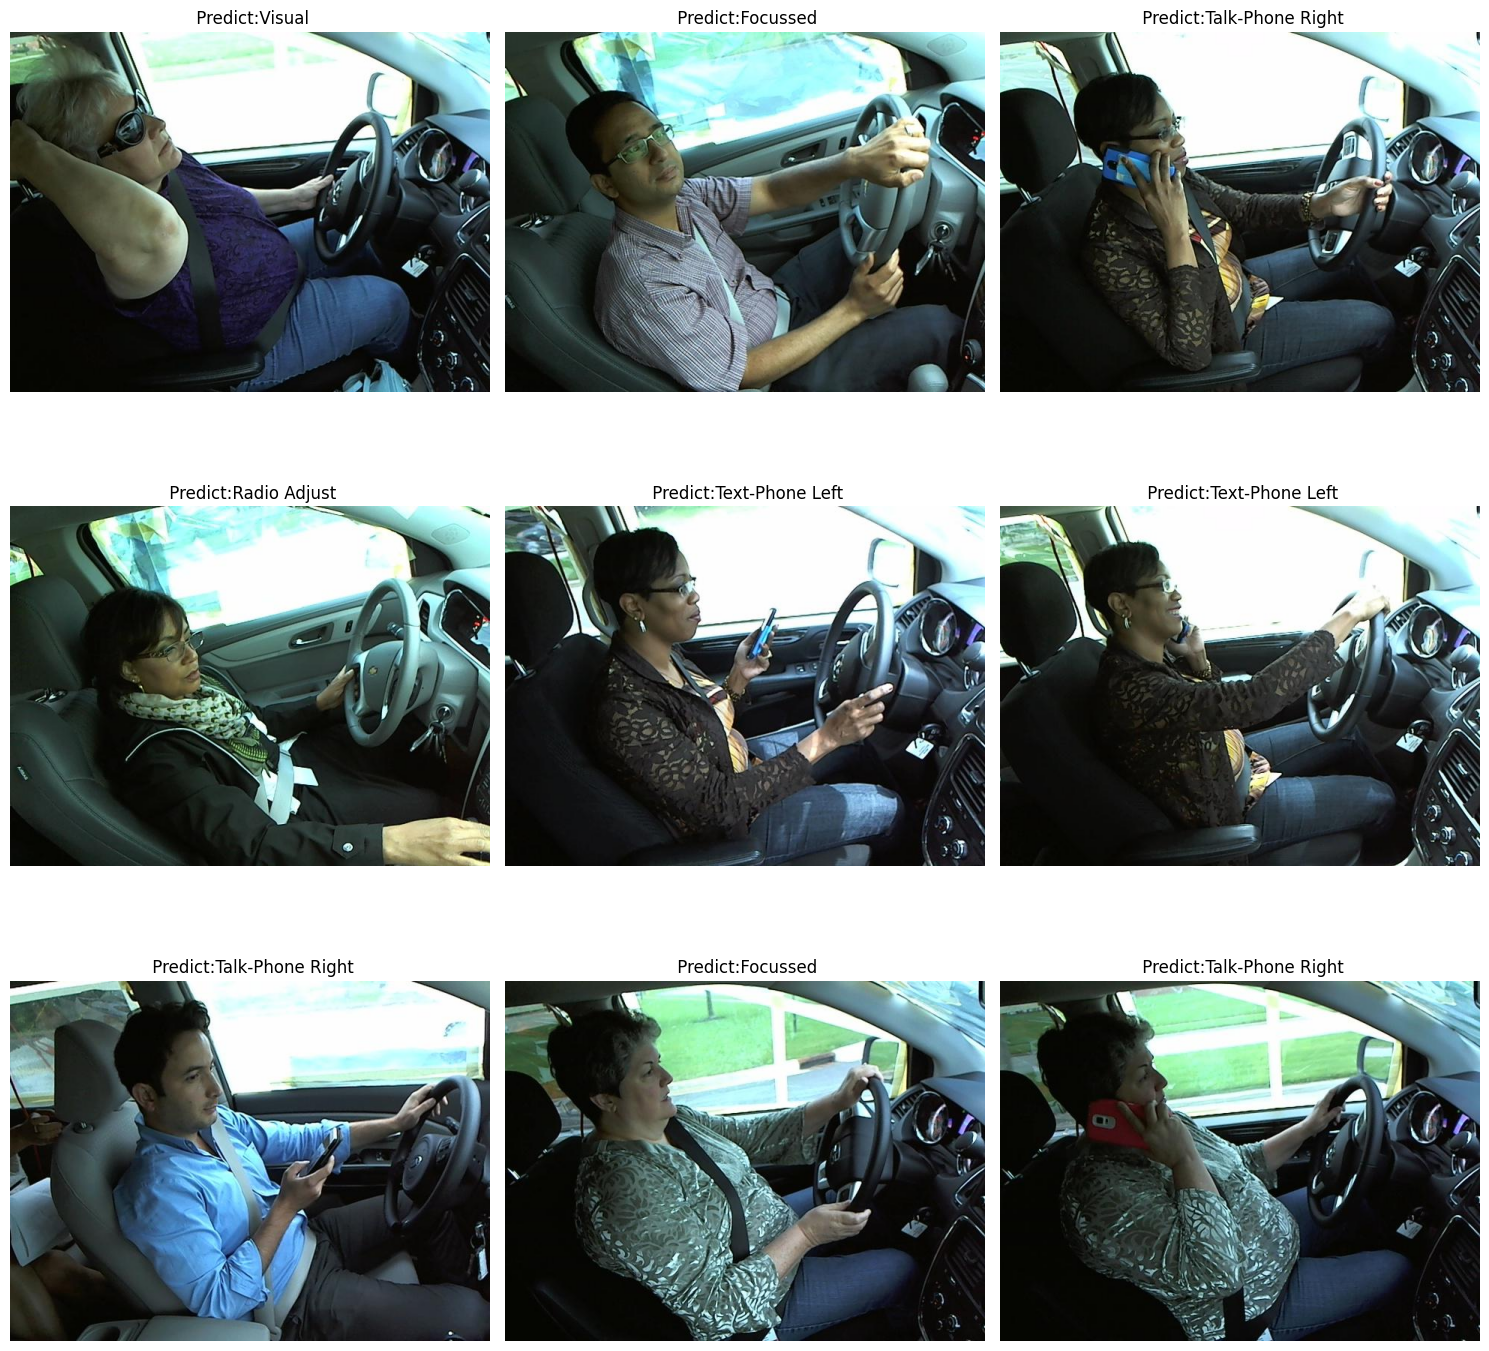

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
img_list = ["img_384.jpg", "img_413.jpg", "img_1031.jpg", "img_1240.jpg", "img_1866.jpg", "img_2072.jpg", "img_2154.jpg", "img_2857.jpg", "img_308.jpg"]
keys = list(meta.keys())
index = [0,1,2,3,4,5,6,7,8,9]
x_ticks = list(meta.values())

grid_x = 3
grid_y = 3
plots = grid_x*grid_y

plt.figure(figsize=(grid_y * 5, grid_x * 5))
for idx, image_filename in enumerate(img_list):
    dir_file = "C:/Users/james/Desktop/Diss_project_code/state-farm-distracted-driver-detection/imgs/Unlabled/test/"
    image_path = dir_file + image_filename
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X = create_inputs(pose_model, box_model, image_path)
    predictions = model.predict(X)

    ax = plt.subplot(grid_x, grid_y, idx + 1)
    plt.imshow(image)
    plt.title(" Predict:" + meta[keys[meta_cls_2_num[predictions[0]]]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
filename_list = []
class_imgs_dict = {}

import os
directory = r"C:/Users/james/Desktop/Diss_Code_for_AUC/state-farm-distracted-driver-detection/imgs/train/"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    filename_list.append(filename)
    if os.path.exists(f):
        img_list = []
        for imgs in os.listdir(f):
            img_list.append(imgs)
        class_imgs_dict[filename] = img_list
print(class_imgs_dict)

{'c0': ['img_100026.jpg', 'img_10003.jpg', 'img_100050.jpg', 'img_100074.jpg', 'img_10012.jpg', 'img_100145.jpg', 'img_100191.jpg', 'img_100257.jpg', 'img_100312.jpg', 'img_100337.jpg', 'img_100456.jpg', 'img_10053 - Copy.jpg', 'img_10053.jpg', 'img_100542.jpg', 'img_100598.jpg', 'img_100605.jpg', 'img_100656.jpg', 'img_100665.jpg', 'img_100796.jpg', 'img_100824.jpg', 'img_100828.jpg', 'img_10092.jpg', 'img_100922.jpg', 'img_101015.jpg', 'img_101032.jpg', 'img_101091.jpg', 'img_101113.jpg', 'img_101159.jpg', 'img_101175.jpg', 'img_101196.jpg', 'img_101223.jpg', 'img_101286.jpg', 'img_101383.jpg', 'img_101392.jpg', 'img_10141.jpg', 'img_101414.jpg', 'img_101419.jpg', 'img_101498.jpg', 'img_101555.jpg', 'img_101609.jpg', 'img_101613.jpg', 'img_101668.jpg', 'img_10167.jpg', 'img_101673.jpg', 'img_101702.jpg', 'img_10175.jpg', 'img_101785.jpg', 'img_101859.jpg', 'img_101938.jpg', 'img_102025.jpg', 'img_10206.jpg', 'img_102087.jpg', 'img_10225 - Copy.jpg', 'img_10225.jpg', 'img_10307.jpg', 

In [24]:
import time
import numpy as np
import psutil
latency_list = []
memory_usage_percent_list = []
memory_usage_list = []
cpu_usage_list = []
y_pred = []
y_test = []
for cls in class_imgs_dict.keys():
    count = 0
    
    keypoint_class_dict = {}
    for img in class_imgs_dict[cls]:

        image_dir = directory + cls + "/" + img
        start = time.time()
        X = create_inputs(pose_model, box_model, image_dir)
        predictions = model.predict(X)
        end = time.time()
        y_pred.append(predictions[0])
        y_test.append(cls)
        latency_list.append(end - start)

        memory_info = psutil.virtual_memory()
        memory_usage_percent_list.append(memory_info.percent)
        memory_usage_list.append((memory_info.used)/1024**2)

        cpu_percent = psutil.cpu_percent()
        cpu_usage_list.append(cpu_percent)

        count += 1
        if count >= 202:
            break




image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 person, 77.8ms
Speed: 1.0ms preprocess, 77.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10003.jpg: 480x640 1 person, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10003.jpg: 480x640 1 Steering Wheel, 62.6ms
Speed: 0.0ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\

In [25]:
average_latency = np.mean(latency_list) # in seconds
average_latency_milliseconds = average_latency * 1000

In [26]:
OUT_Str = "The Average Latency for each Prediction is: {:.2f} ms".format(average_latency_milliseconds)
print(OUT_Str)

The Average Latency for each Prediction is: 246.77 ms


In [27]:
count = len(latency_list)
total_time = sum(latency_list)

Throughput = count/total_time

OUT_Str = "The Throughput is: {:.2f} predictions per second".format(Throughput)
print(OUT_Str)

The Throughput is: 4.05 predictions per second


In [28]:
Memory_usage_total = np.mean(memory_usage_list)
OUT_Str = "The Average RAM Memory Usage is: {:.2f} MB".format(Memory_usage_total)
print(OUT_Str)

The Average RAM Memory Usage is: 13161.03 MB


In [29]:
Memory_usage = np.mean(memory_usage_percent_list)
OUT_Str = "The Average % RAM Memory Usage is: {:.2f}% ".format(Memory_usage)
print(OUT_Str)

The Average % RAM Memory Usage is: 81.90% 


In [30]:
CPU_usage = np.mean(cpu_usage_list)
OUT_Str = "The Average CPU Usage is: {:.2f}%".format(CPU_usage)
print(OUT_Str)

The Average CPU Usage is: 8.07%


In [31]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5955445544554455


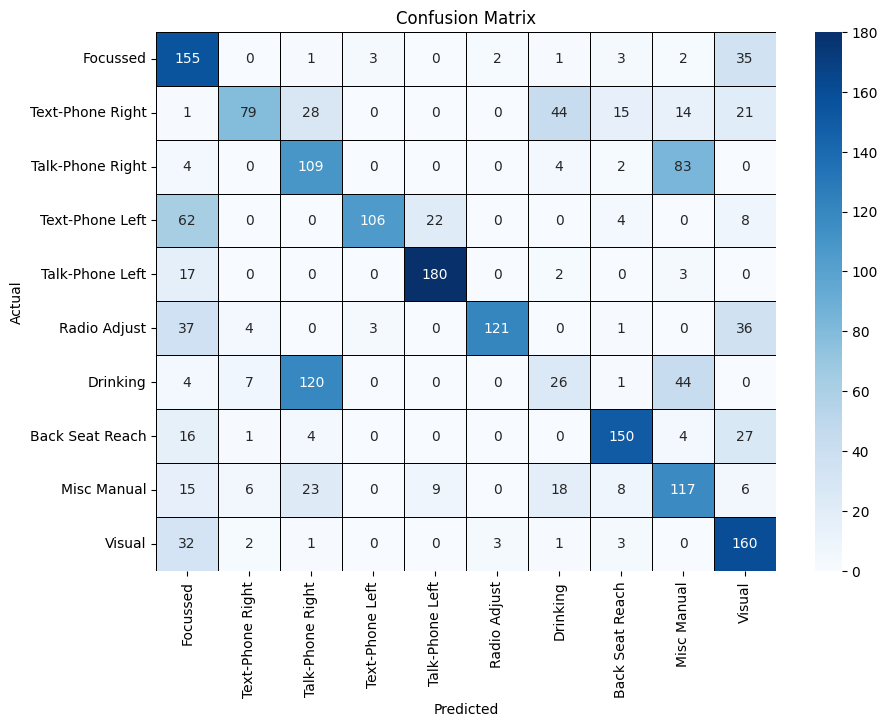

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
ticks = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5, 9.5]
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(confusion, cmap="Blues", annot=True, fmt = ".5g", cbar=True, linewidths = 0.5,linecolor="black")
plt.xticks(ticks=ticks, labels=list(meta.values()), rotation=90)
plt.yticks(ticks=ticks, labels=list(meta.values()), rotation=-0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, confusion_matrix
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
print("f1:        " + str(f1))
print("Precision: " + str(precision))
print("recall:    " + str(recall))

f1:        0.5916183829243297
Precision: 0.6448070026578601
recall:    0.5955445544554455


In [34]:
def change_from_10_cls_2_cls(y_arr):
    new_list = []
    for cls in y_arr:
        if cls == "c0":
            new_list.append("c0")
        else:
            new_list.append("c1")
    return new_list

In [35]:
y_adj_pred = change_from_10_cls_2_cls(y_pred)
y_adj_test = change_from_10_cls_2_cls(y_test)
accuracy = accuracy_score(y_adj_pred, y_adj_test)
print("Accuracy:", accuracy)

Accuracy: 0.8836633663366337
